In [1]:
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

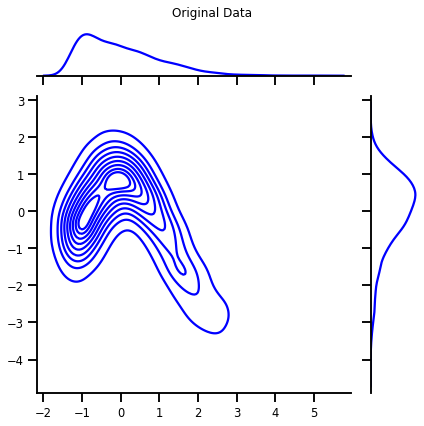

In [3]:
from sklearn.preprocessing import StandardScaler
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)
data = StandardScaler().fit_transform(data)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

In [4]:
X = jnp.array(data, dtype=np.float32)

## Mixture Distribution

In [5]:
from distrax._src.utils import jittable
import abc
from chex import Array, dataclass
from typing import Tuple, Optional

In [6]:
from rbig_jax.transforms.base import Bijector
from jax.random import PRNGKey
from chex import Array, dataclass
from rbig_jax.transforms.parametric.mixture.gaussian import mixture_gaussian_cdf_vectorized, mixture_gaussian_invcdf_vectorized, mixture_gaussian_log_pdf_vectorized

## KMeans

In [7]:
from sklearn.cluster import KMeans

def init_means_kmeans(X: np.ndarray, n_components: int, **kwargs):
    """Initialize means with K-Means
    
    Parameters
    ----------
    X : np.ndarray
        (n_samples, n_features)
    n_components : int
        the number of clusters for the K-Means
    
    Returns
    -------
    clusters : np.ndarray
        (n_features, n_components)"""
    clusters = KMeans(n_clusters=n_components, **kwargs).fit(X).cluster_centers_.T
    
    return clusters

def init_means_kmeans_marginal(X: np.ndarray, n_components: int, **kwargs):
    """Initialize means with K-Means
    
    Parameters
    ----------
    X : np.ndarray
        (n_samples, n_features)
    n_components : int
        the number of clusters for the K-Means
    
    Returns
    -------
    clusters : np.ndarray
        (n_features, n_components)"""
    
    clusters = []
    
    for iX in X.T:
        clusters.append(KMeans(n_clusters=n_components, **kwargs).fit(iX[:, None]).cluster_centers_.T)
    
    return np.vstack(clusters)

In [8]:
clusters = init_means_kmeans_marginal(X, 50)
clusters.shape

(2, 50)

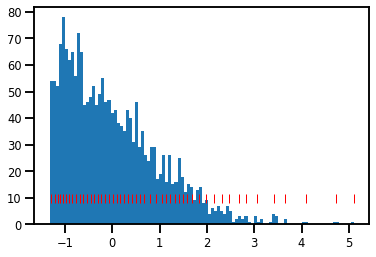

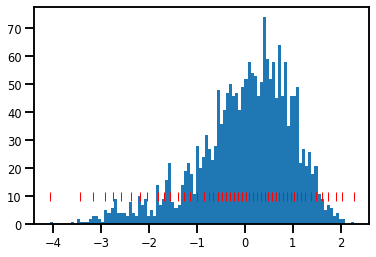

In [9]:
fig, ax = plt.subplots()
ax.hist(X[:, 0], bins=100)
ax.plot(clusters[0], 10*np.ones_like(clusters[1]), "|", color="Red")
plt.show()

fig, ax = plt.subplots()
ax.hist(X[:, 1], bins=100)
ax.plot(clusters[1], 10*np.ones_like(clusters[1]), "|", color="Red")
plt.show()

In [10]:
clusters = init_means_kmeans(X, 50)
clusters.shape

(2, 50)

In [11]:
clusters[0]

array([ 1.8637431e-01,  1.8893806e+00, -1.1233871e+00,  5.9313685e-01,
       -5.6703907e-01,  3.1197367e+00,  9.2687392e-01,  2.3831265e+00,
       -9.2584842e-01, -2.4642864e-01, -1.2508258e+00, -7.9633963e-01,
        3.4797746e-01, -3.6243168e-01,  4.0890388e+00, -6.8731099e-01,
        5.4350829e-01, -1.0176293e+00, -1.3560621e-01, -2.7827969e-01,
        1.4320871e+00, -9.2395073e-01,  2.0584550e+00,  7.0667511e-01,
       -1.7607284e-01,  2.9644914e+00,  8.1736475e-01,  3.5357833e-01,
       -4.5844197e-01,  9.5882452e-01, -7.3946434e-01,  3.7669411e-01,
       -1.2155460e+00, -1.0760021e+00, -2.1951580e-02, -1.1882735e+00,
        1.6681671e+00, -4.2708760e-01,  1.2713858e+00,  4.8577075e+00,
        1.5627640e-01, -3.3932806e-03, -7.9243928e-01,  2.9667646e-01,
       -7.1352547e-01,  1.5053511e+00,  2.5011308e+00,  3.5718577e+00,
        1.2045552e+00,  1.9269799e+00], dtype=float32)

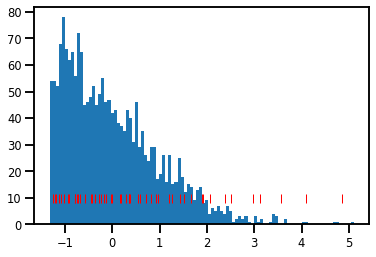

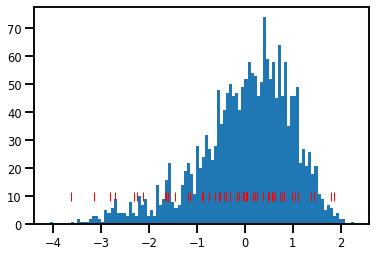

In [12]:
fig, ax = plt.subplots()
ax.hist(X[:, 0], bins=100)
ax.plot(clusters[0], 10*np.ones_like(clusters[1]), "|", color="Red")
plt.show()

fig, ax = plt.subplots()
ax.hist(X[:, 1], bins=100)
ax.plot(clusters[1], 10*np.ones_like(clusters[1]), "|", color="Red")
plt.show()

## Gaussian Mixture Model

In [13]:
from sklearn.mixture import GaussianMixture

In [25]:
def init_means_GMM(X: np.ndarray, n_components: int, **kwargs):
    """Initialize means with K-Means
    
    Parameters
    ----------
    X : np.ndarray
        (n_samples, n_features)
    n_components : int
        the number of clusters for the K-Means
    
    Returns
    -------
    clusters : np.ndarray
        (n_features, n_components)"""
    clusters = KMeans(n_clusters=n_components, **kwargs).fit(X).cluster_centers_.T
    
    return clusters

def init_means_GMM_marginal(X: np.ndarray, n_components: int, **kwargs):
    """Initialize means with K-Means
    
    Parameters
    ----------
    X : np.ndarray
        (n_samples, n_features)
    n_components : int
        the number of clusters for the K-Means
    
    Returns
    -------
    clusters : np.ndarray
        (n_features, n_components)"""
    
    weights, means, covariances = [], [], []
    
    for iX in X.T:
        clf = GaussianMixture(n_components=n_components, covariance_type="diag", **kwargs).fit(iX[:, None])
        weights.append(clf.weights_)
        means.append(clf.means_.T)
        covariances.append(clf.covariances_.T)
    
    return np.vstack(weights), np.vstack(means), np.vstack(covariances)

In [28]:
weights, means, covs = init_means_GMM_marginal(X, 50)
weights.shape, means.shape, covs.shape

((2, 50), (2, 50), (2, 50))

In [33]:
weights[0]

array([0.02643855, 0.02150008, 0.03208269, 0.00332466, 0.01782979,
       0.02484432, 0.00688225, 0.02796624, 0.001     , 0.01046292,
       0.01150601, 0.02568472, 0.03258961, 0.02534969, 0.02096269,
       0.01160637, 0.03427382, 0.01472896, 0.00099982, 0.04029728,
       0.04040161, 0.02052636, 0.00609831, 0.02122207, 0.001     ,
       0.04133187, 0.02482027, 0.01062348, 0.0095744 , 0.00519606,
       0.01252792, 0.04431537, 0.03226986, 0.01920292, 0.03100714,
       0.01993048, 0.0005    , 0.02018991, 0.02102092, 0.02939027,
       0.04007862, 0.01895961, 0.02808353, 0.00747623, 0.02653722,
       0.0259611 , 0.02703002, 0.00400011, 0.00990838, 0.0104855 ])

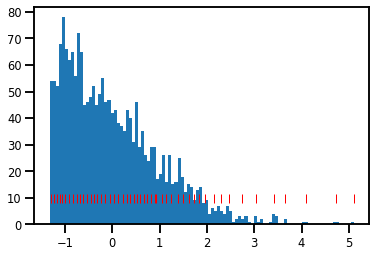

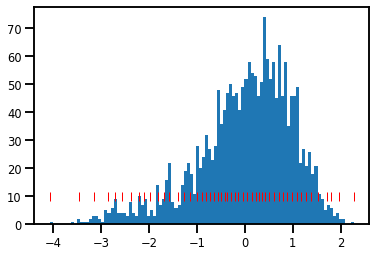

In [29]:
fig, ax = plt.subplots()
ax.hist(X[:, 0], bins=100)
ax.plot(means[0], 10*np.ones_like(means[1]), "|", color="Red")
plt.show()

fig, ax = plt.subplots()
ax.hist(X[:, 1], bins=100)
ax.plot(means[1], 10*np.ones_like(means[1]), "|", color="Red")
plt.show()

In [34]:
@dataclass
class MixtureParams:
    means: Array
    log_scales: Array
    prior_logits: Array

class MixtureGaussianCDF(Bijector):
    def __init__(self, n_components: int=10, init_method: str="normal", return_X: bool=False) -> None:
        
        self.n_components = n_components
        self.return_X = return_X
        if init_method.lower() not in ["normal", "kmeans", "kmeans_marg"]:
            raise ValueError(f"unrecognized init method: {init_method}")
        else:
            self.init_method = init_method.lower()
    
    def init_params(self, rng: PRNGKey, n_features: int, X: Optional[Array]=None, **kwargs) -> dataclass:
        # initialize mixture

        if self.init_method == "kmeans" and X is not None:
            
            means = init_means_kmeans_marginal(X, self.n_components, **kwargs)
        elif self.init_method == "kmeans_marg" and X is not None:
            
            means = init_means_kmeans(X, self.n_components, **kwargs)
        else:
            means = jax.random.normal(key=rng, shape=(n_features, self.n_components))
            
        log_scales = np.zeros((n_features, self.n_components))
        prior_logits = np.ones((n_features, self.n_components)) / self.n_components

        init_params = MixtureParams(
            means=means, log_scales=log_scales, prior_logits=prior_logits
        )
        
        if self.return_X:
        
            return self.forward(init_params, X), init_params
        else:
            return init_params
    
    def forward_and_log_det(self,
        params: MixtureParams, inputs: Array, **kwargs
    ) -> Tuple[Array, Array]:

        # forward transformation with batch dimension
        outputs = mixture_gaussian_cdf_vectorized(
            inputs, params.prior_logits, params.means, np.exp(params.log_scales),
        )

        # log abs det, all zeros
        logabsdet = mixture_gaussian_log_pdf_vectorized(
            inputs, params.prior_logits, params.means, np.exp(params.log_scales),
        )

        return outputs, logabsdet

    def inverse_and_log_det(self,
        params: MixtureParams, inputs: Array, **kwargs
    ) -> Tuple[Array, Array]:

        # transformation
        outputs = mixture_gaussian_invcdf_vectorized(
            inputs, params.prior_logits, params.means, np.exp(params.log_scales),
        )
        # log abs det, all zeros
        logabsdet = mixture_gaussian_log_pdf_vectorized(
            outputs, params.prior_logits, params.means, np.exp(params.log_scales),
        )

        return outputs, logabsdet

<Figure size 432x288 with 0 Axes>

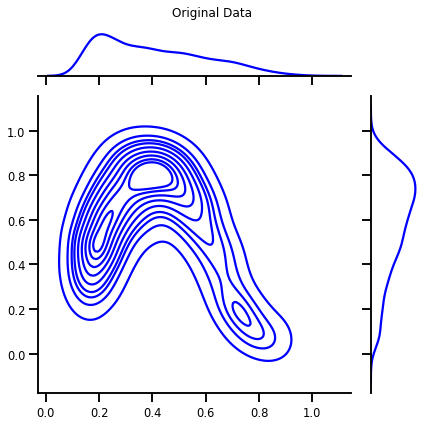

In [35]:
mcdf_layer = MixtureGaussianCDF(10, "kmeans_marg", True)

# initialize the keys
KEY = jax.random.PRNGKey(123)
rng, params_rng = jax.random.split(KEY, 2)

# initialize params
X_l1, params = mcdf_layer.init_params(params_rng, 2, X=X)



plot_joint(X_l1, "blue", "Original Data", kind='kde', logger=False)

In [36]:
params_gmm = MixtureParams(means=np.array(means), log_scales=np.log(np.sqrt(np.array(covs))), prior_logits=np.array(weights))

<Figure size 432x288 with 0 Axes>

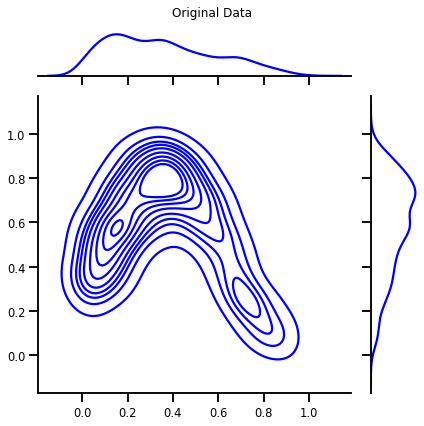

In [40]:
# transformation
X_l1 = mcdf_layer.forward(params_gmm, X)

plot_joint(X_l1, "blue", "Original Data", kind='kde', logger=False)

In [101]:
X_approx = mcdf_layer.inverse(params, X_trans)

<Figure size 432x288 with 0 Axes>

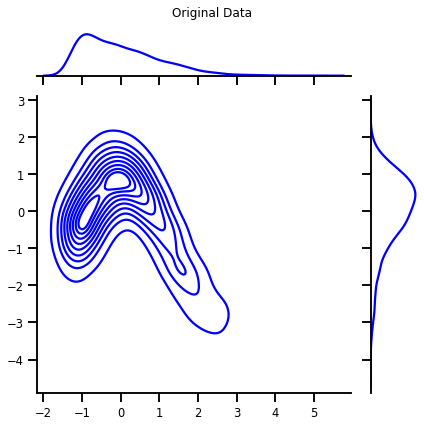

In [102]:
plot_joint(X_approx, "blue", "Original Data", kind='kde', logger=False)

## Logit Transform

In [121]:
from distrax._src.bijectors.sigmoid import _more_stable_sigmoid, _more_stable_softplus

class Logit(Bijector):
    def __init__(self, eps: float=1e-9, return_X: bool=True) -> None:
        
        self.eps = eps
        self.return_X = return_X
    
    def init_params(self, rng: PRNGKey, n_features: int, **kwargs) -> dataclass:
        
        
        if self.return_X:
        
            return (), X
        else:
            return ()
    
    def inverse_and_log_det(self,
        params: dataclass, x: Array, **kwargs
    ) -> Tuple[Array, Array]:
        return _more_stable_sigmoid(x), self.forward_log_det_jacobian(params, x)

    def inverse_log_det_jacobian(self, params: dataclass, x: Array) -> Array:
        return -_more_stable_softplus(-x) - _more_stable_softplus(x)
    
    def forward_and_log_det(self,
        params: dataclass, x: Array, **kwargs
    ) -> Tuple[Array, Array]:

        y = jnp.log(x) - jnp.log1p(-x)

        return y, -self.inverse_log_det_jacobian(params, y)

In [122]:
logit_layer = Logit()

# initialize the keys
KEY = jax.random.PRNGKey(123)
rng, logit_rng = jax.random.split(rng, 2)

# initialize params
params = logit_layer.init_params(logit_rng, 2, X=X)


params

()

### Forward Transform

<Figure size 432x288 with 0 Axes>

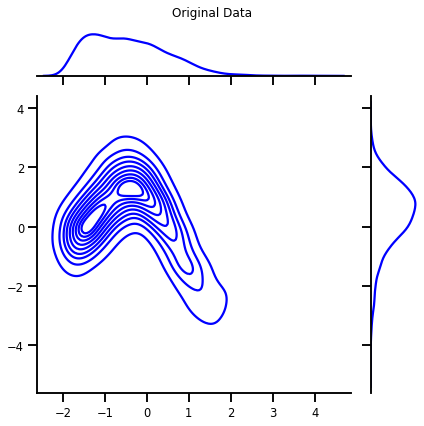

In [125]:
# transformation
X_l2 = logit_layer.forward(params, X_trans)

plot_joint(X_l2, "blue", "Original Data", kind='kde', logger=False)

### Inverse Transformation

<Figure size 432x288 with 0 Axes>

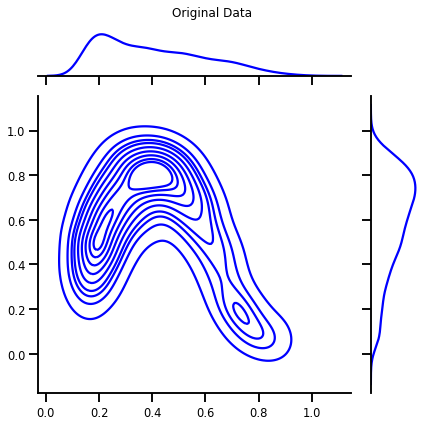

In [134]:
# transformation
X_l1_approx = logit_layer.inverse(params, X_l2)

plot_joint(X_l1_approx, "blue", "Original Data", kind='kde', logger=False)

In [129]:
X.min(), X.max(), X_trans.min(), X_trans.max(), X_l2.min(), X_l2.max()

(DeviceArray(-4.066332, dtype=float32),
 DeviceArray(5.107872, dtype=float32),
 DeviceArray(0.00920642, dtype=float32),
 DeviceArray(0.9835878, dtype=float32),
 DeviceArray(-4.6786046, dtype=float32),
 DeviceArray(4.093182, dtype=float32))

## Rotation

In [141]:
from rbig_jax.transforms.parametric.householder import householder_transform, householder_inverse_transform
from rbig_jax.transforms.rotation import compute_projection
@dataclass
class HouseHolderParams:
    V: Array


class HouseHolder(Bijector):
    def __init__(self, n_reflections: int=10, init_method: str="random", return_X: bool=False) -> None:
        
        self.n_reflections = n_reflections
        self.return_X = return_X
        if init_method.lower() not in ["random", "pca"]:
            raise ValueError(f"unrecognized init method: {init_method}")
        else:
            self.init_method = init_method.lower()
    
    def init_params(self, rng: PRNGKey, n_features: int, **kwargs) -> dataclass:
        # initialize mixture

        if self.init_method == "ica":
            
            raise NotImplementedError(f"ICA method hasn't been implemented yet.")
        elif self.init_method == "pca":
            
            X = kwargs.pop("X", None)
            V = compute_projection(X)
        else:
            V = jax.nn.initializers.orthogonal()(key=rng, shape=(self.n_reflections, n_features))
            
        init_params = HouseHolderParams(V=V)
        
        if self.return_X:
        
            return init_params, X
        else:
            return init_params
    
    def forward_and_log_det(self,
        params: HouseHolder, inputs: Array, **kwargs
    ) -> Tuple[Array, Array]:

        # forward transformation with batch dimension
        outputs = jax.vmap(householder_transform, in_axes=(0, None))(
            inputs, params.V
        )

        # log abs det, all zeros
        logabsdet = np.zeros_like(inputs)

        return outputs, logabsdet

    def inverse_and_log_det(self,
        params: HouseHolder, inputs: Array, **kwargs
    ) -> Tuple[Array, Array]:

        outputs = jax.vmap(householder_inverse_transform, in_axes=(0, None))(
            inputs, params.V
        )

        # log abs det, all zeros
        logabsdet = np.zeros_like(inputs)

        return outputs, logabsdet

## Householder Transformation

In [145]:
X_t = np.random.randn(100,10)

In [159]:
hh_layer = HouseHolder(2, "random")

# initialize the keys
KEY = jax.random.PRNGKey(123)
rng, hh_rng = jax.random.split(rng, 2)

# initialize params
params = hh_layer.init_params(hh_rng, 2, X=X_l2)


params

HouseHolderParams(V=DeviceArray([[-0.97380865,  0.2273698 ],
             [-0.2273698 , -0.97380847]], dtype=float32))

In [157]:
params

HouseHolderParams(V=DeviceArray([[ 0.4415343 ,  0.89724433],
             [-0.89724433,  0.4415343 ]], dtype=float32))

### Forward Transformation

<Figure size 432x288 with 0 Axes>

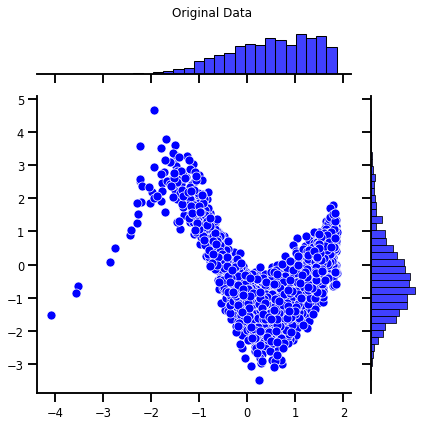

In [160]:
# transformation
X_l3 = hh_layer.forward(params, X_l2)

plot_joint(X_l3, "blue", "Original Data", kind='scatter', logger=False)